In [45]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import pickle
from timeit import default_timer as timer
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import nltk as nltk
import math

from IPython.display import display
import os
import cProfile, pstats, io
#import memory_profiler
import psutil
import gc

# Enabling eager execution and set other configurations

In [46]:
tf.enable_eager_execution()
process = psutil.Process(os.getpid())

print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB
#https://stackoverflow.com/questions/938733/total-memory-used-by-python-process

#https://pypi.org/project/memory-profiler/ - did not use it

UNK = '</s>'
FILLER = '</fill>'

MAX_BATCH_SIZE = 1024
MAX_WORD_COUNT = 40

NO_LABEL = 'NO_LABEL'

tf.set_random_seed(1)

5766.1875 MB


# Load Google vectors

In [47]:
dirname = os.getcwd()
datasetPath = os.path.join(dirname, 'datasets/')
outfile = datasetPath +'google_word_corpus.pic'

with open(outfile, 'rb') as pickle_file:    
    googleCorpus, google_corpus_word_to_int, google_corpus_int_to_word = pickle.load(pickle_file)
googleSet = pd.read_csv(datasetPath+'GoogleNews-vectors-negative10.txt', sep=' ', header=None)

print(len(googleCorpus))
print(len(google_corpus_word_to_int))
print(len(google_corpus_int_to_word))
print(googleSet.shape)
print(googleSet.head())

1965716
1965716
1965716
(1965716, 11)
     0         1         2         3         4         5         6         7   \
0  </s>  0.001129 -0.000896  0.000319  0.001534  0.001106 -0.001404 -0.000031   
1    ##  0.168945 -0.062988 -0.000265  0.063477  0.087402 -0.030029  0.001450   
2  ####  0.107910  0.094238 -0.018555 -0.018799 -0.007111 -0.139648 -0.046631   
3     $  0.113770 -0.117676  0.064941  0.132812  0.054932 -0.099121  0.071289   
4   ###  0.149414 -0.191406  0.044189  0.104980  0.016846 -0.135742 -0.085449   

         8         9         10  
0 -0.000420 -0.000576  0.001076  
1 -0.077637  0.199219 -0.001770  
2 -0.063965  0.098145  0.135742  
3 -0.013306  0.271484 -0.083984  
4  0.074219  0.088867 -0.044922  


In [48]:
# TO BE DONE - Appropriate value should be added for FILLER (or) it has to be trained
# May be it is a good idea to view the close words
fill_data = {0:FILLER}
for i in range(1, googleSet.shape[1]):
    fill_data[i] = i
googleSet = googleSet.append(fill_data, ignore_index=True)

print(googleSet.shape)
print(googleSet.head())

temp = list(googleCorpus)
temp.append(FILLER)
googleCorpus = set(temp)
#corpus_length = len(google_corpus_word_to_int) # are we sure the index that has been added is the same ????
corpus_length = googleSet.shape[0] -1
google_corpus_word_to_int[FILLER] = corpus_length
google_corpus_int_to_word[corpus_length] = FILLER


googleWords = googleSet.iloc[:,0:1]
googleVectors = googleSet.iloc[:,1:]

(1965717, 11)
     0         1         2         3         4         5         6         7   \
0  </s>  0.001129 -0.000896  0.000319  0.001534  0.001106 -0.001404 -0.000031   
1    ##  0.168945 -0.062988 -0.000265  0.063477  0.087402 -0.030029  0.001450   
2  ####  0.107910  0.094238 -0.018555 -0.018799 -0.007111 -0.139648 -0.046631   
3     $  0.113770 -0.117676  0.064941  0.132812  0.054932 -0.099121  0.071289   
4   ###  0.149414 -0.191406  0.044189  0.104980  0.016846 -0.135742 -0.085449   

         8         9         10  
0 -0.000420 -0.000576  0.001076  
1 -0.077637  0.199219 -0.001770  
2 -0.063965  0.098145  0.135742  
3 -0.013306  0.271484 -0.083984  
4  0.074219  0.088867 -0.044922  


In [49]:
#UNK = '<unk>'

#glovePath = '/media/kandy/hdd/master-thesis/datasets/'
#outfile = glovePath +'glove_word_corpus.pic'

#with open(outfile, 'rb') as pickle_file:    
#    gloveCorpus, glove_corpus_word_to_int, glove_corpus_int_to_word = pickle.load(pickle_file)
#gloveSet = pd.read_csv(glovePath+'glove.42B.10d.txt', sep=' ', header=None)
#print(gloveSet.shape)
#print(gloveSet.head())

#gloveWords = gloveSet.iloc[:,0:1]
#gloveVectors = gloveSet.iloc[:,1:]

# Load training and test dataset

                                            sentence  \
0  pierre </s> </s> </s> years old </s> will join...   
1  mr. </s> is chairman of elsevier n.v. </s> the...   
2  rudolph agnew </s> </s> years old and former c...   
3  the asbestos fiber </s> </s> </s> is unusually...   
4  lorillard inc. </s> the unit of new </s> loews...   

                                                tree  
0  [[[(NO_LABEL\n  (NO_LABEL\n    (NO_LABEL\n    ...  
1  [[[(NO_LABEL\n  (NO_LABEL\n    (NO_LABEL\n    ...  
2  [[[(NO_LABEL\n  (NO_LABEL\n    (NO_LABEL\n    ...  
3  [[[(NO_LABEL\n  (NO_LABEL\n    (NO_LABEL\n    ...  
4  [[[(NO_LABEL\n  (NO_LABEL\n    (NO_LABEL\n    ...  
(43834, 2)


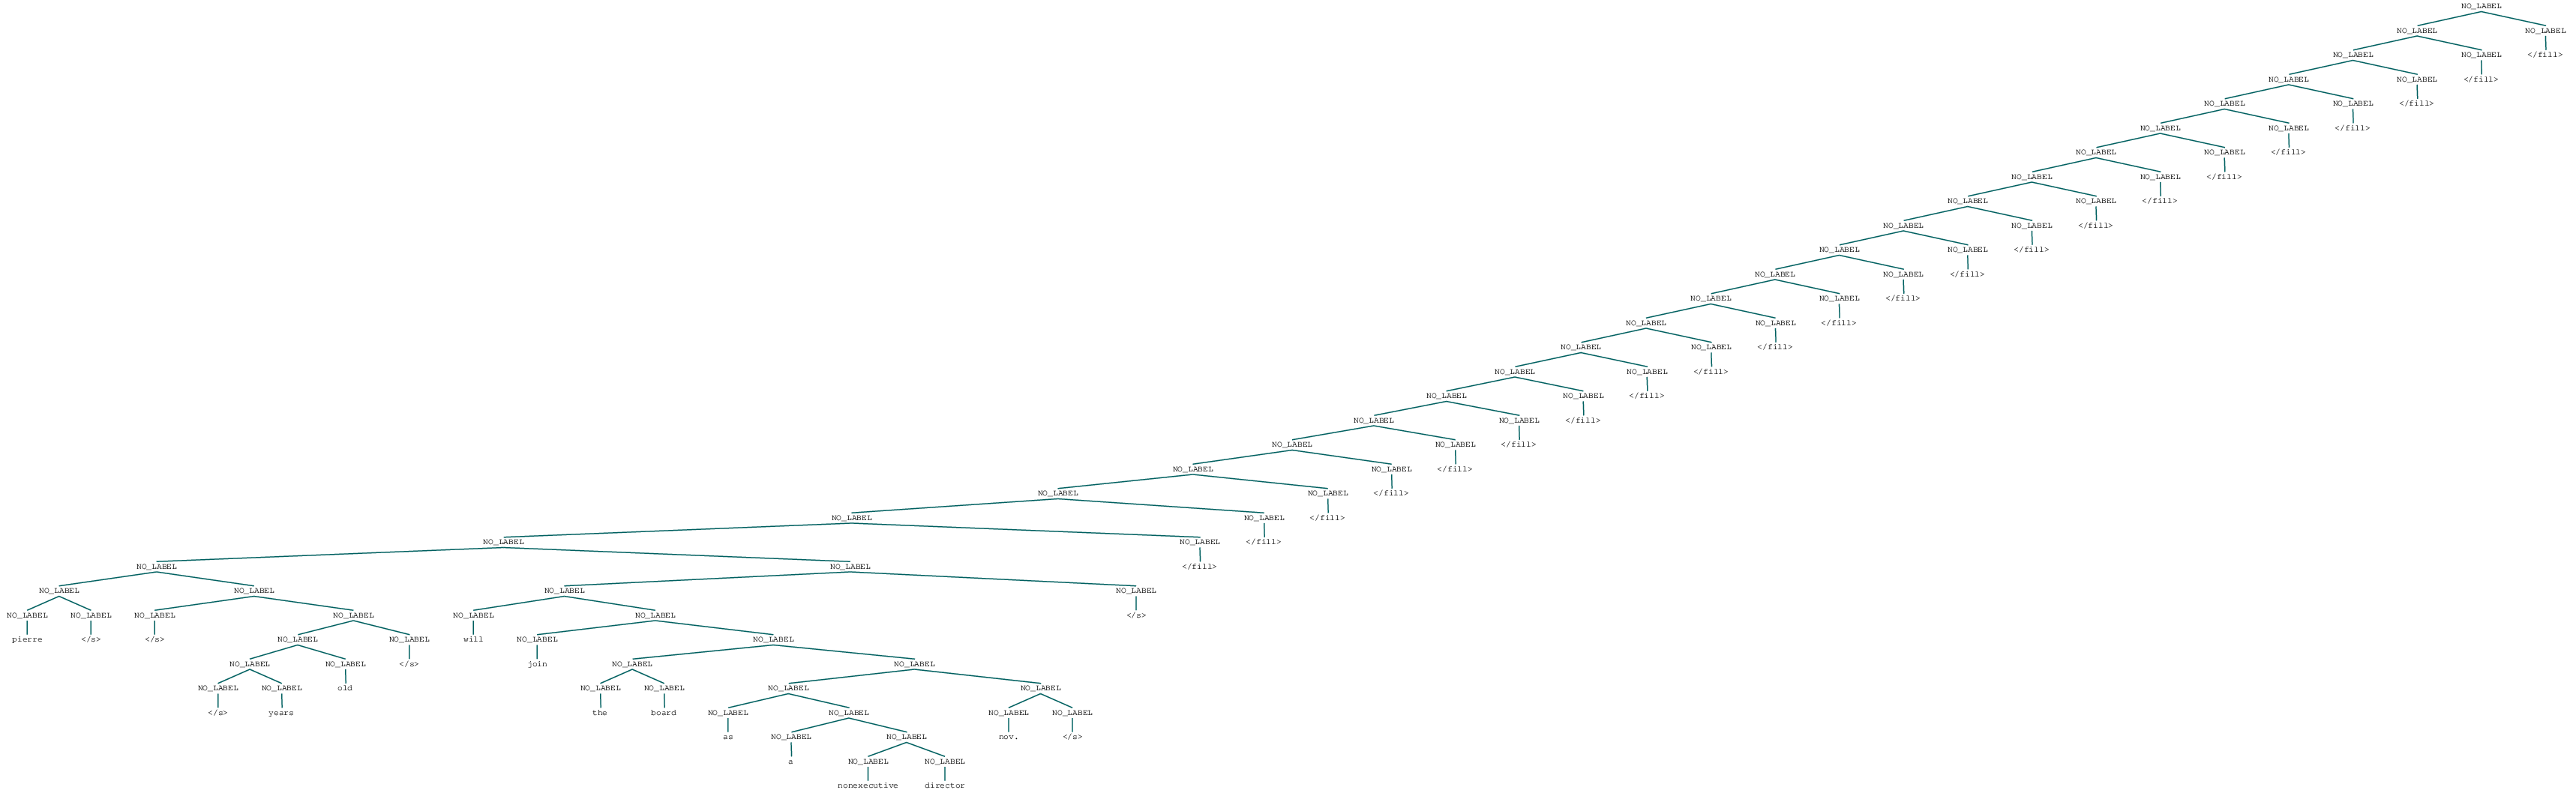

In [50]:
#treeDataframe = pd.read_csv(datasetPath+'constituency-parsing-data-all-UNK.csv', sep=' ', header=None )
#treeDataframe = pd.read_csv(datasetPath+'constituency-parsing-data-all-UNK-less-40-words.csv', sep=' ', header=None )
treeDataframe = pd.read_csv(datasetPath+'constituency-parsing-data-40-UNK-NOLABEL.csv', sep=' ', header=None )

treeDataframe.columns =['sentence', 'tree']
treeDataframe['tree'] = treeDataframe['tree'].apply(nltk.Tree.fromstring)

print(treeDataframe.head())
print(treeDataframe.shape)
display(treeDataframe.iat[0,1])

In [51]:
def convert_imdb_corpus_into_int(sentence):
    words = sentence.split()
    words_to_num = [google_corpus_word_to_int[word] for word in words]
    return words_to_num

treeDataframe_num = treeDataframe.copy()
treeDataframe_num['sentence'] = treeDataframe_num['sentence'].apply(convert_imdb_corpus_into_int)
treeDataframe_num.head()

,sentence,tree
0,"[599296, 0, 0, 0, 14194, 16954, 0, 605855, 650...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
1,"[1102067, 0, 559233, 51668, 394585, 9088, 6022...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
2,"[390769, 945758, 0, 0, 14194, 16954, 343368, 1...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
3,"[977344, 395210, 425661, 0, 0, 0, 559233, 1385...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
4,"[8994, 229259, 0, 977344, 47419, 394585, 10442...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...


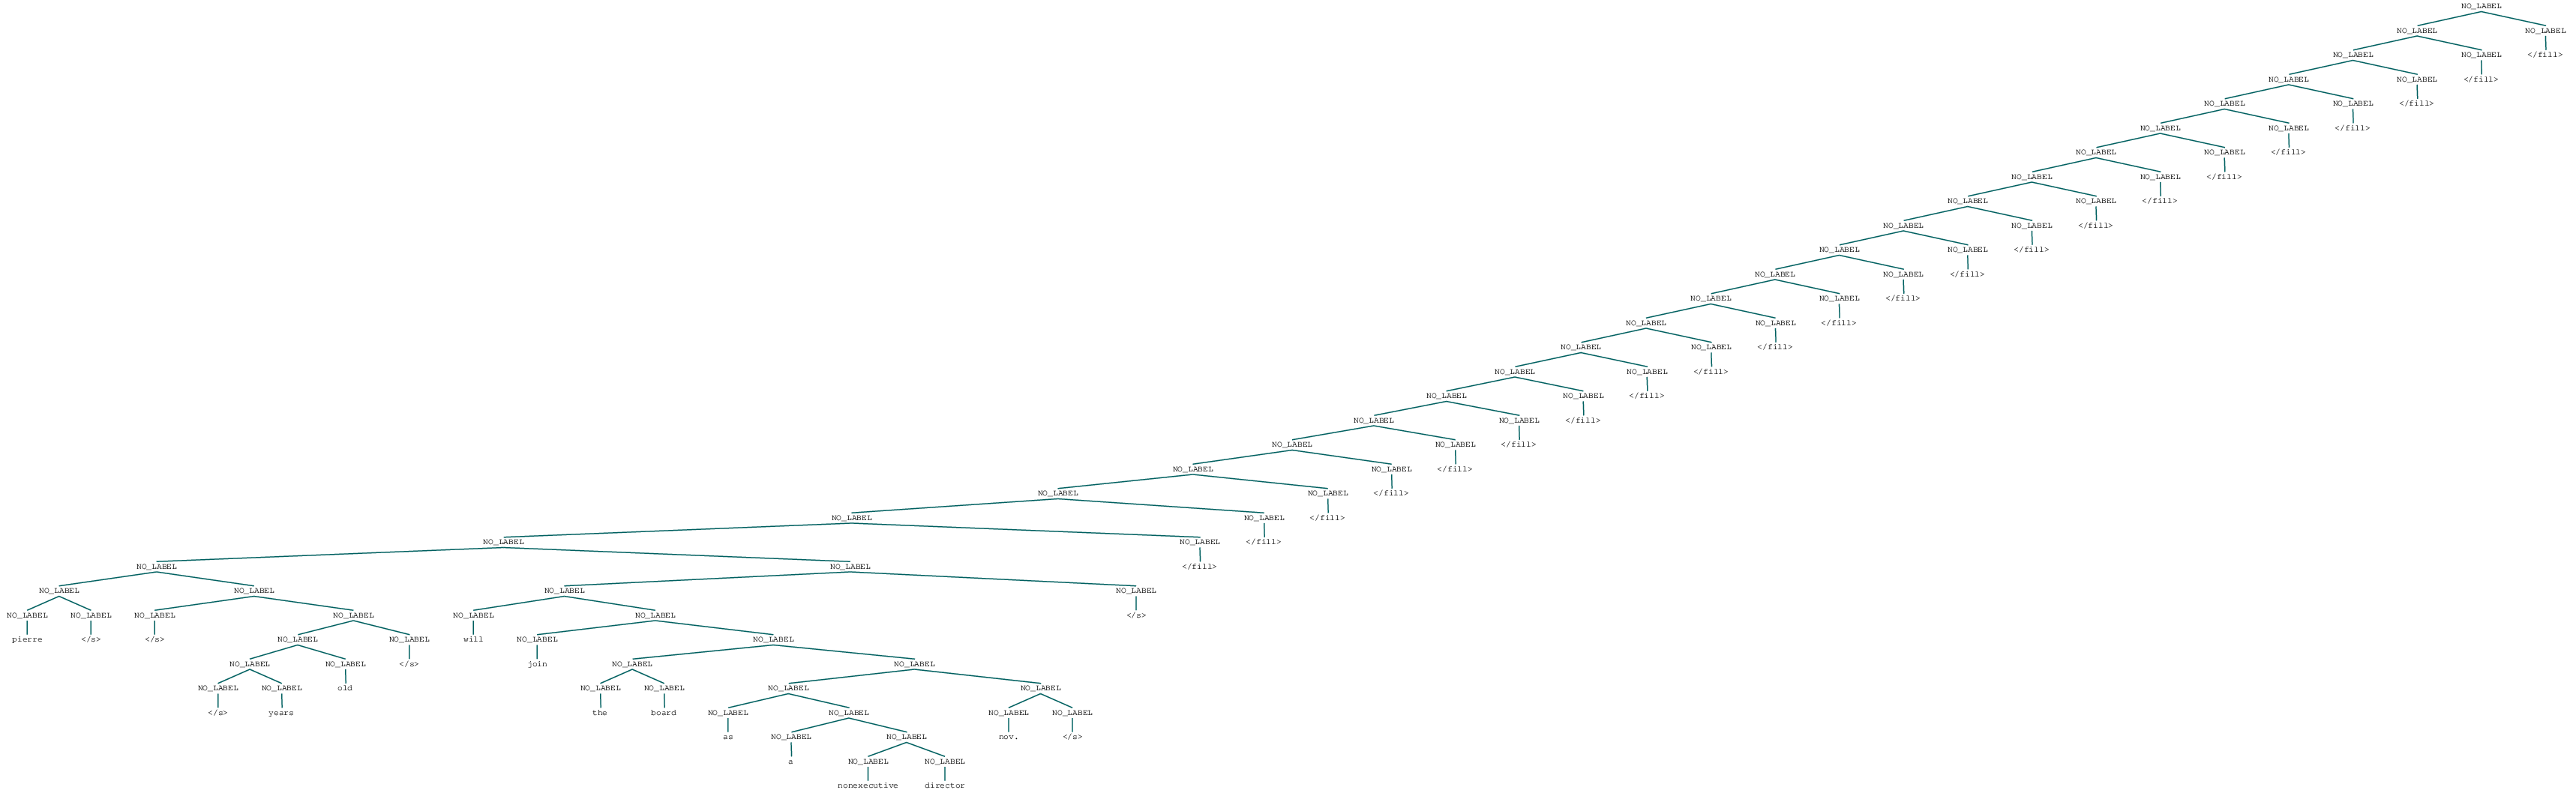

[0 2 2 2 1 0 3 6 5 4 5 4 3 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


In [52]:
#compute the tree formation index for the golden tree
# This does a depth first traversal of tree and gets the left child index of each sub-tree formation
def get_tree_formation_index(tree, leaves, input_list):
    if(type(tree[0]) == type('some string')):
        # we use the leaves() function to get the indexes of child elements
        # everytime when an element is found, it is important to remove them to avoid getting them reused
        leaveIndex = leaves.index(tree[0])
        leaves[leaveIndex]=''
        return leaveIndex
    
    leftIndex = get_tree_formation_index(tree[0], leaves, input_list)
    rightIndex = get_tree_formation_index(tree[1], leaves, input_list)
    input_list.append(leftIndex)
    return leftIndex

def get_tree_formation_indexes(tree):
    tree_combination= []
    tree_leaves = tree.leaves()
    get_tree_formation_index(tree, tree_leaves, tree_combination)
    
    # the indexes obtained for forming the tree assumes the size of the leaves is unchanged.
    # But everytime when a subtree is formed two nodes are merged together and hence size reduces
    
    # the below code is to make sure the index is updated as according to where the merge happened
    # all the indexes which are right to where the merge happened has to get subtracted by 1 
    # because of removal of a node
    
    for i in range(len(tree_combination)-1):
        for j in range(i+1, len(tree_combination)):
            if(tree_combination[j] > tree_combination[i]):
                tree_combination[j] = tree_combination[j] - 1
    return np.array(tree_combination)

copiedTree = treeDataframe_num.iat[0,1].copy()
display(copiedTree)
tree_formation_indexes = get_tree_formation_indexes(copiedTree)
print(tree_formation_indexes)

In [53]:
columnList = []
ACT_COL_NAME = 'a'
for i in range(MAX_WORD_COUNT-1):
    columnList.append(ACT_COL_NAME+str(i))
#get the list of indexes and store it in column 'a'. Afterwards break the 'a' to MAX_WORD_COUNT-1 columns
treeDataframe_num[ACT_COL_NAME] = treeDataframe_num['tree'].apply(get_tree_formation_indexes)
treeDataframe_num[columnList] = pd.DataFrame(treeDataframe_num[ACT_COL_NAME].values.tolist(), index= treeDataframe_num.index, dtype=np.int32)
treeDataframe_num.drop(columns=[ACT_COL_NAME], inplace=True)
treeDataframe_num.head()

,sentence,tree,a0,a1,a2,a3,a4,a5,a6,a7,...,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38
0,"[599296, 0, 0, 0, 14194, 16954, 0, 605855, 650...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,0,2,2,2,1,0,3,6,...,0,0,0,0,0,0,0,0,0,0
1,"[1102067, 0, 559233, 51668, 394585, 9088, 6022...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,0,4,8,7,6,5,4,3,...,0,0,0,0,0,0,0,0,0,0
2,"[390769, 945758, 0, 0, 14194, 16954, 343368, 1...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,0,2,2,4,8,7,6,5,...,0,0,0,0,0,0,0,0,0,0
3,"[977344, 395210, 425661, 0, 0, 0, 559233, 1385...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,1,0,2,1,0,2,6,5,...,3,3,2,1,0,0,0,0,0,0
4,"[8994, 229259, 0, 977344, 47419, 394585, 10442...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,0,2,4,5,4,3,7,6,...,0,0,0,0,0,0,0,0,0,0


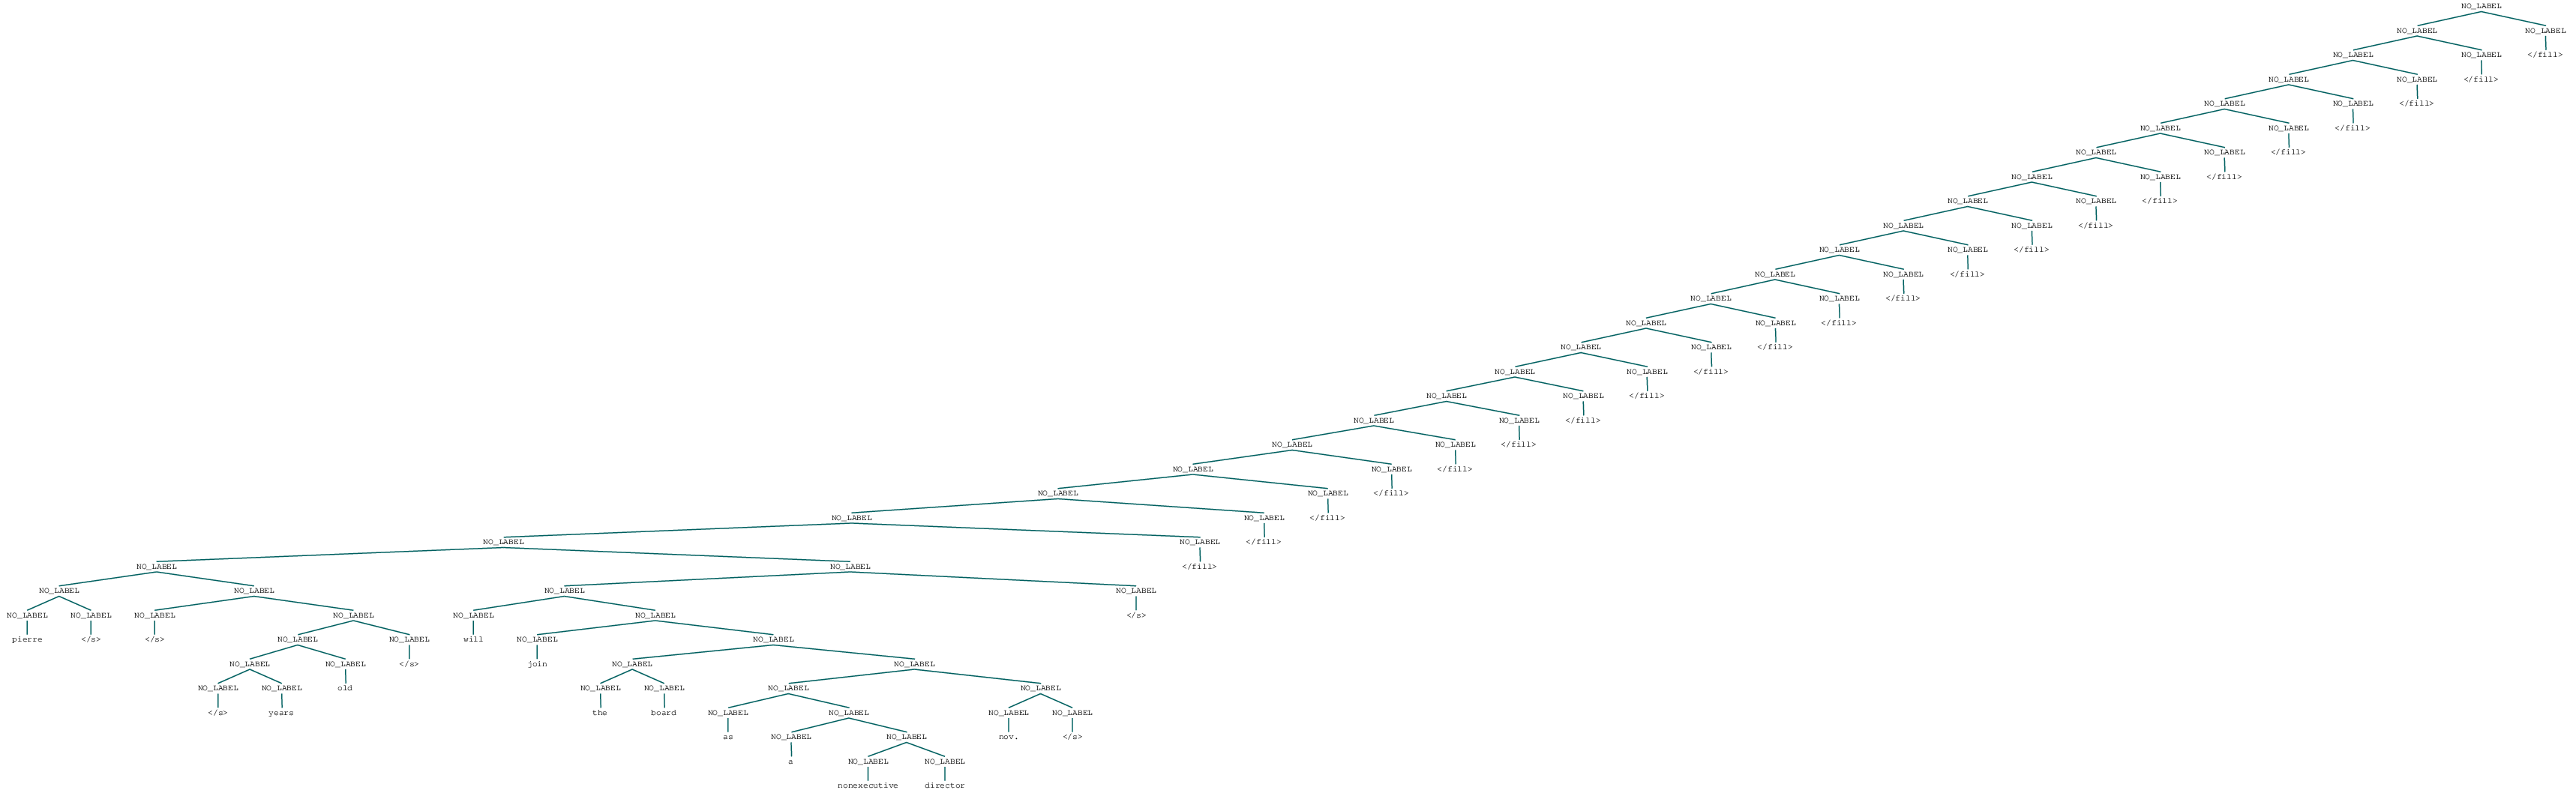

{(11, 16), (0, 27), (0, 20), (7, 16), (11, 14), (0, 36), (0, 28), (0, 32), (0, 21), (0, 24), (0, 17), (0, 37), (3, 6), (3, 4), (8, 16), (0, 29), (0, 33), (0, 22), (2, 6), (12, 14), (0, 25), (0, 18), (9, 10), (0, 38), (9, 16), (0, 30), (0, 34), (0, 23), (3, 5), (0, 1), (0, 26), (13, 14), (0, 19), (0, 39), (0, 6), (0, 31), (7, 17), (0, 35), (15, 16)}
Length: 39


In [54]:
def get_tree_formation_set(tree, leaves, input_set):
    if(type(tree[0]) == type('some string')):
        # we use the leaves() function to get the indexes of child elements
        # everytime when an element is found, it is important to remove them to avoid getting them reused
        leaveIndex = leaves.index(tree[0])
        leaves[leaveIndex]=''
        return (leaveIndex, leaveIndex)
    
    leftIndex = get_tree_formation_set(tree[0], leaves, input_set)
    rightIndex = get_tree_formation_set(tree[1], leaves, input_set)
    new_index = (leftIndex[0], rightIndex[1])
    input_set.add(new_index)
    return new_index

def get_tree_formation_sets(tree):
    tree_combination= set()
    tree_leaves = tree.leaves()
    get_tree_formation_set(tree, tree_leaves, tree_combination)
    
    return tree_combination

copiedTree = treeDataframe_num.iat[0,1].copy()
display(copiedTree)
tree_formation_sets = get_tree_formation_sets(copiedTree)
print(tree_formation_sets)
print('Length:',len(tree_formation_sets))

In [55]:
ACT_COL_NAME = 'a'
ACT_SET = ACT_COL_NAME + '_set'
 
#get the list of indexes and store it in column 'a'. Afterwards break the 'a' to MAX_WORD_COUNT-1 columns
treeDataframe_num[ACT_SET] = treeDataframe_num['tree'].apply(get_tree_formation_sets)
treeDataframe_num[['sentence','tree',ACT_SET]].head(n=2)

,sentence,tree,a_set
0,"[599296, 0, 0, 0, 14194, 16954, 0, 605855, 650...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,"{(11, 16), (0, 27), (0, 20), (7, 16), (11, 14)..."
1,"[1102067, 0, 559233, 51668, 394585, 9088, 6022...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,"{(0, 27), (10, 11), (0, 20), (5, 6), (0, 14), ..."


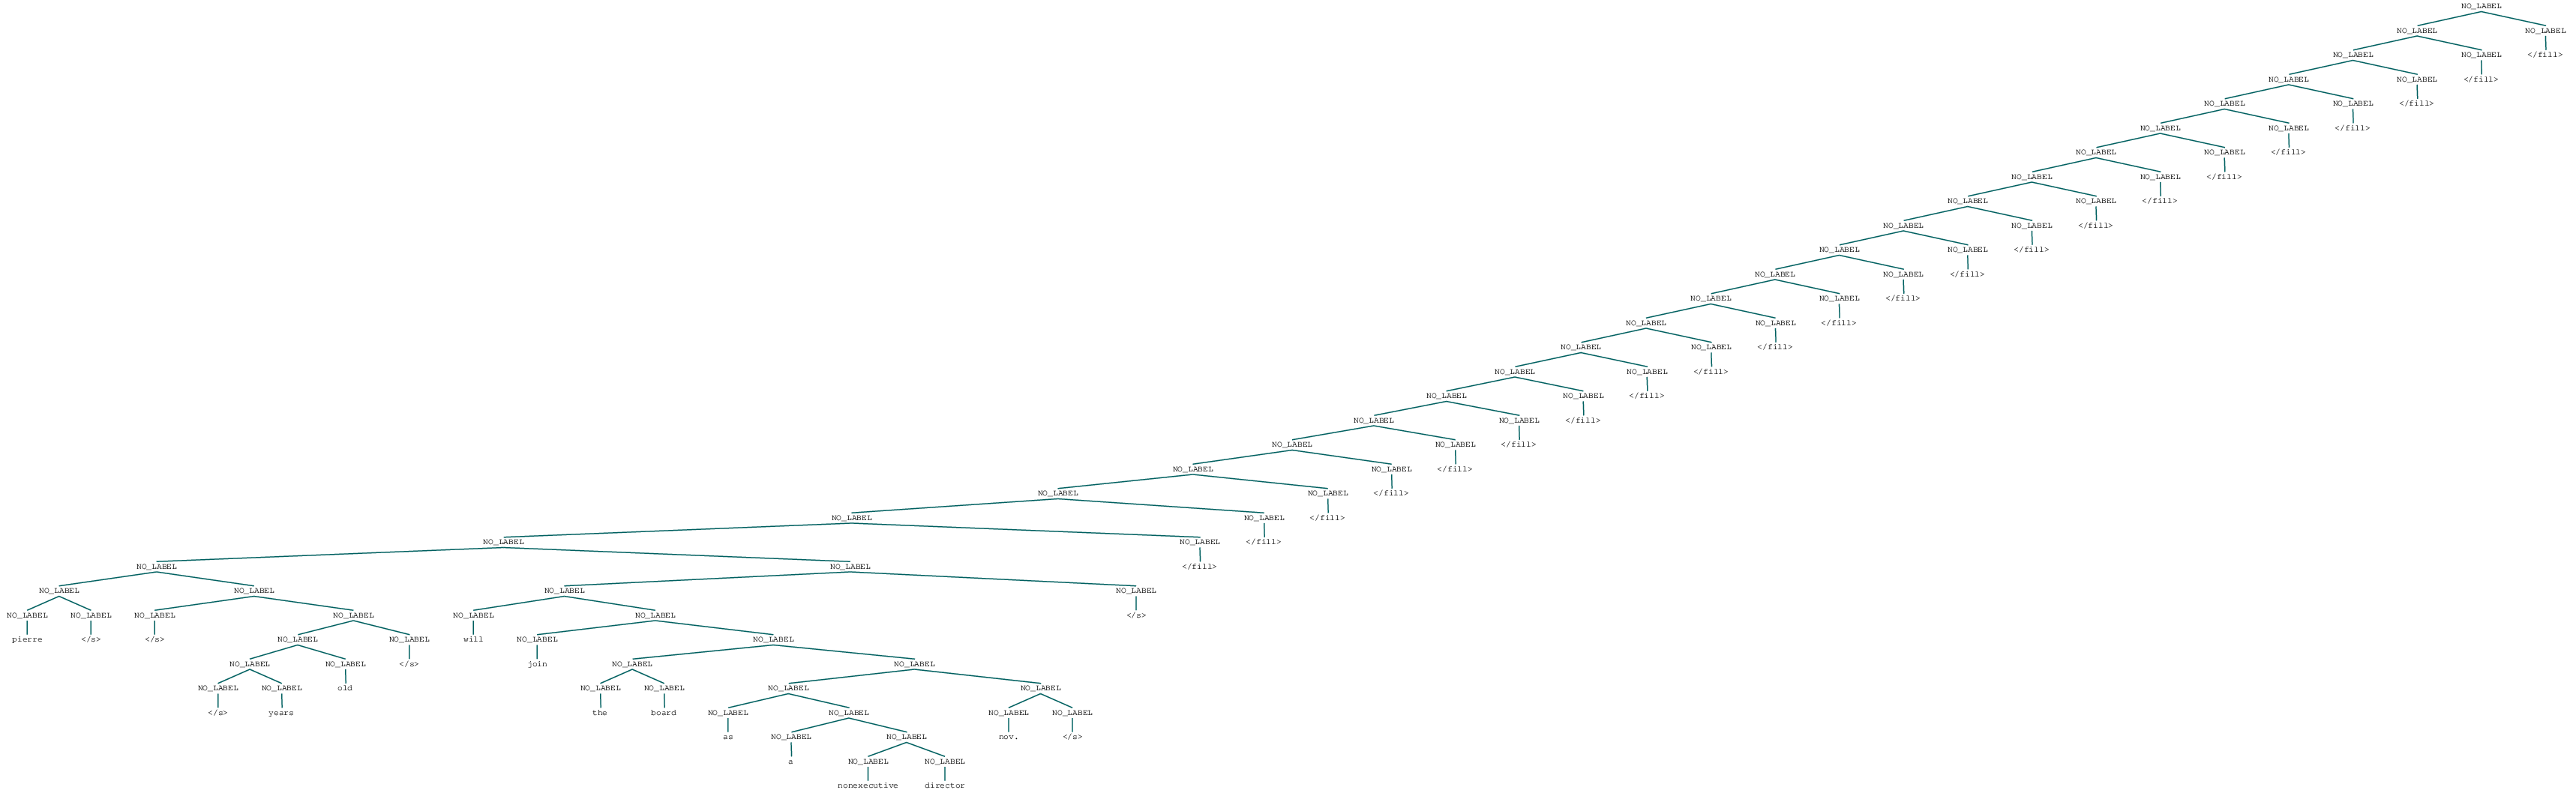

In [56]:
def form_tree(one_row,colName):
    print
    words = one_row['sentence']
    words = [google_corpus_int_to_word[word] for word in words]
    sub_trees = [nltk.Tree(NO_LABEL,[word]) for word in words]

    for j in range(MAX_WORD_COUNT-1):
        combine_index = one_row[colName+str(j)]
        combine_index = int(combine_index)
        right_tree = sub_trees.pop(combine_index+1)
        left_tree = sub_trees.pop(combine_index)
        sub_trees.insert(combine_index, nltk.Tree(NO_LABEL, [left_tree, right_tree]))
        
    return sub_trees[0]

formed_tree = form_tree(treeDataframe_num.iloc[0], ACT_COL_NAME)
display(formed_tree)

In [57]:
def compare_trees(actual, predicted):
    actual_sub_trees = actual.subtrees()
    
    total_count = 0.0 #len(actual_sub_trees)
    match_count = 0.0
    
    for sub_tree in actual_sub_trees:
        #print('Sub Tree:', sub_tree)
        #print(predicted_sub_trees)
        predicted_sub_trees = predicted.subtrees()
        for temp_tree in predicted_sub_trees:
            #print(' ', temp_tree)
            if(sub_tree == temp_tree):
                match_count = match_count + 1.0
                break
        total_count = total_count + 1.0
        #break
    #print('Match:', match_count,' Total:', total_count)
    
    return [match_count/total_count, match_count, total_count]

#compare_trees(treeDF_train.iat[2,1], treeDF_train.iat[2,1])

t1 = nltk.Tree.fromstring("(S (NP I) (VP (V saw) (NP him)))")
sub_trees = t1.subtrees()
for sub_tree in sub_trees:
    print(sub_tree)

# there is no mismatch so, score should be 0
score_result = compare_trees(treeDataframe_num.iat[0,1], t1)
print(score_result)

# use the tree which is computed from formation indexes
# it is a exact replica - so score should be 1
score_result = compare_trees(treeDataframe_num.iat[0,1], formed_tree)
print(score_result)

(S (NP I) (VP (V saw) (NP him)))
(NP I)
(VP (V saw) (NP him))
(V saw)
(NP him)
[0.0, 0.0, 79.0]
[1.0, 79.0, 79.0]


In [100]:
treeDF_train, treeDF_test = sklearn.model_selection.train_test_split(treeDataframe_num, test_size=0.999)
print(treeDF_train.shape)
print(treeDF_test.shape)

#treeDF_train = treeDataframe_num.iloc[treeDataframe_num.shape[0]-50:treeDataframe_num.shape[0]]
#treeDF_test = treeDataframe_num.iloc[0:treeDataframe_num.shape[0]-50]
#print(treeDF_train.shape)
#print(treeDF_test.shape)

(43, 42)
(43791, 42)


# Model and the Parameters

In [101]:
parametersPath = os.path.join(dirname, 'parameters/')

with open(parametersPath+'parameters_latest.pic', 'rb') as pickle_file:    
    parameters_load = pickle.load(pickle_file)
    
with open(parametersPath+'parameters.pic', 'rb') as pickle_file:    
    parameters_load = pickle.load(pickle_file)

In [124]:
STATE_SIZE = 10
embeddings = tfe.Variable(name='embeddings', validate_shape= googleVectors.shape, 
                          initial_value=googleVectors.values, 
                          dtype=tf.float32, trainable=False)
w = tfe.Variable(name='w', validate_shape=(2*googleVectors.shape[1], STATE_SIZE), 
                 #initial_value=parameters_load[0],
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(2*googleVectors.shape[1], STATE_SIZE)),
                 dtype=tf.float32)
b = tfe.Variable(name='b', validate_shape=(1, STATE_SIZE),
                 #initial_value=parameters_load[1],
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(1, STATE_SIZE)),
                 dtype=tf.float32)

w_score = tfe.Variable(name='w_score', validate_shape=(STATE_SIZE, 1), 
                 #initial_value=parameters_load[2],
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(STATE_SIZE, 1)),
                 dtype=tf.float32)
b_score = tfe.Variable(name='b_score', validate_shape=(1, 1),
                 #initial_value=parameters_load[3],
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(1, 1)),
                 dtype=tf.float32)

#parameters = [w, b, w_score, b_score]
#with open(parametersPath+'parameters.pic', 'wb') as pickle_file:    
#    pickle.dump(parameters, pickle_file)

#print(w)
#print(b)
#print(w_score)
#print(b_score)

#try to get the filler and see the sequence of number exists
embeddings[treeDataframe_num.iat[0,0][30]]

<tf.Tensor: id=116305046, shape=(10,), dtype=float32, numpy=array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.], dtype=float32)>

In [125]:
def embedding_lookup(input_words):
    words = tf.nn.embedding_lookup(embeddings, input_words)
    return words

print(google_corpus_int_to_word[treeDataframe_num.iat[0,0][39]])
print(embedding_lookup(treeDataframe_num.iat[0,0][30]))
print(embedding_lookup(treeDataframe_num.iat[0,0][39]))

print(google_corpus_int_to_word[0])
print(embedding_lookup([0,1]))
print(googleSet.loc[0:1])

</fill>
tf.Tensor([ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], shape=(10,), dtype=float32)
tf.Tensor([ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], shape=(10,), dtype=float32)
</s>
tf.Tensor(
[[ 1.1291504e-03 -8.9645386e-04  3.1852722e-04  1.5335083e-03
   1.1062622e-03 -1.4038086e-03 -3.0517578e-05 -4.1961670e-04
  -5.7601929e-04  1.0757446e-03]
 [ 1.6894531e-01 -6.2988281e-02 -2.6512146e-04  6.3476562e-02
   8.7402344e-02 -3.0029297e-02  1.4495850e-03 -7.7636719e-02
   1.9921875e-01 -1.7700195e-03]], shape=(2, 10), dtype=float32)
     0         1         2         3         4         5         6         7   \
0  </s>  0.001129 -0.000896  0.000319  0.001534  0.001106 -0.001404 -0.000031   
1    ##  0.168945 -0.062988 -0.000265  0.063477  0.087402 -0.030029  0.001450   

         8         9         10  
0 -0.000420 -0.000576  0.001076  
1 -0.077637  0.199219 -0.001770  


## Training

In [126]:
gc.collect()

pr = cProfile.Profile()
pr.enable()

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)

start_memory = process.memory_info().rss
start_time = timer()

PREDICT_COL_NAME = 'p'
PREDICT_SET = PREDICT_COL_NAME + '_set'

def compare_trees_row_using_set(one_row):
    actual = one_row[ACT_SET]
    predict = one_row[PREDICT_SET]
    
    common = len(predict.intersection(actual))
    total = len(predict)
    return common/total


# calculate the upper limit for BATCH_COUNT
train_data = treeDF_train
data_size = train_data.shape[0]
BATCH_COUNT = int(math.ceil(data_size/MAX_BATCH_SIZE))
print('StartMemory (MB): ', start_memory/(1024*1024))
#print('Epoch Batch Loss Accuracy Time(sec) Memory(MB)')
print('Epoch Loss Accuracy Time(sec) Memory(MB)')

for epoch in range(50) :
    total_sum_loss = 0.0
    total_sum_accuracy = 0.0
    total_tree_count = 0
    for batch_no in range(BATCH_COUNT):

        #print('Epoch:', epoch,'Batch:', batch_no,'/',BATCH_COUNT)
        
        # Recorded only batch-wise. that is enough to calculate gradients and apply them
        with tf.GradientTape() as tape:
            
            # Extract the appropriate batch data. For the last batch, the size of the data can be lesser
            start = batch_no * MAX_BATCH_SIZE
            stop = start + MAX_BATCH_SIZE
            mini_batch_data = train_data.iloc[start:stop]
            BATCH_SIZE = mini_batch_data.shape[0]
            
            result_set = pd.DataFrame(mini_batch_data, index=mini_batch_data.index)
            
            # get the word vectors - its shape will be (no. of sentence, no.of words, no. of states)
            data = embedding_lookup(mini_batch_data['sentence'])
            gold_data = embedding_lookup(mini_batch_data['sentence'])
            #data = tf.slice(embedding_lookup_out, [0,0,0], [BATCH_SIZE,MAX_WORD_COUNT,STATE_SIZE])
            #print(data.shape)
            
            NO_OF_SENTENCE = data.shape[0] # which is same as BATCH_SIZE
            NO_OF_WORDS = data.shape[1]

            total_predict_score = tf.zeros((BATCH_SIZE,1))
            total_actual_score = tf.zeros((BATCH_SIZE,1))
            
            # enumerate through all the word combinations
            # find the best combination, replace with respective two words
            # do it untill only one word is present
            for word_counter in range(NO_OF_WORDS-1):

                # concatenate the word combinations - first data will contain 1st to n-1th word and 
                # second data will contain 2nd to nth word
                first_data = tf.slice(data, [0,0,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
                second_data = tf.slice(data, [0,1,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
                concatenated_data = tf.concat([first_data, second_data], axis=2)

                # applying linear and non-linear transformation to output STATE_SIZE dimensions
                # this becomes the representation vector for phrases
                reshaped_data = tf.reshape(concatenated_data, (-1,2*STATE_SIZE))
                output_data = tf.tanh(tf.matmul(reshaped_data, w) + b)
                reshaped_output_data = tf.reshape(output_data, (NO_OF_SENTENCE,-1,STATE_SIZE))
                
                # compute score of the above transformation to rank them
                scored_data = tf.matmul(output_data, w_score) + b_score
                reshaped_scored_data = tf.reshape(scored_data, (NO_OF_SENTENCE,-1,1))
                
                max_scored_data = tf.reduce_max(reshaped_scored_data, axis=1)
                squeezed_max_score = tf.squeeze(max_scored_data)
                total_predict_score = tf.add(total_predict_score, squeezed_max_score)
                
                # get the list of indexes whose scores are high
                argmax_score = tf.argmax(reshaped_scored_data, axis=1, output_type=tf.int32)
                squeeze_argmax_score = tf.squeeze(argmax_score)
                
                result_set.loc[mini_batch_data.index, PREDICT_COL_NAME+str(word_counter)] = squeeze_argmax_score.numpy().astype(int).tolist()
                
                # convert the indexing to support reshaping of 2D matrix. this is important to
                # remove the word vector at argmax position
                range_data = (tf.range(0, NO_OF_SENTENCE) * NO_OF_WORDS)
                range_data = tf.reshape(range_data, (NO_OF_SENTENCE,1))
                range_data = range_data + argmax_score
                # convert the indexes to support reshaping of 2D matrix with a word 
                # removed for every sentence. This is important because having got the word removed
                # this will help replace the phrase vector at argmax position for sentences with n-1 words
                range_data_minus = (tf.range(0, NO_OF_SENTENCE) * (NO_OF_WORDS-1))
                range_data_minus = tf.reshape(range_data_minus, (NO_OF_SENTENCE,1))
                range_data_minus = range_data_minus + argmax_score

                # create a bool list with true values of size sentences*words
                # replace the values at argmax position with false
                reshaped_data = tf.reshape(data, (-1,STATE_SIZE))
                range_data_list = tf.squeeze(range_data).numpy().tolist()
                bool_mask_data = [True] * (NO_OF_SENTENCE*NO_OF_WORDS)
                for i in range_data_list:
                    bool_mask_data[i] = False
                # use the boolean mask to filter the rows (axis=0)
                reshaped_new_data = tf.boolean_mask(reshaped_data, bool_mask_data, axis=0)
                
                # create a bool list with true values of size sentences*(words-1)
                # replace the values at argmax position with false
                range_data_minus_list = tf.squeeze(range_data_minus).numpy().tolist()
                bool_mask_data = [True] * (NO_OF_SENTENCE*(NO_OF_WORDS-1))
                for i in range_data_minus_list:
                    bool_mask_data[i] = False
                # replace the input words with phrase vectors at argmax position(bool mask data)
                data = tf.where(bool_mask_data, reshaped_new_data, output_data)
                data = tf.reshape(data,shape=(NO_OF_SENTENCE, -1, STATE_SIZE))
                
                # REPEAT THE SAME PROCESS (with minor changes) FOR GOLDEN TREE SCORE COMPUTATION
                first_gold_data = tf.slice(gold_data, [0,0,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
                second_gold_data = tf.slice(gold_data, [0,1,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
                concatenated_gold_data = tf.concat([first_gold_data, second_gold_data], axis=2)
                reshaped_gold_data = tf.reshape(concatenated_gold_data, (-1,2*STATE_SIZE))
                output_gold_data = tf.tanh(tf.matmul(reshaped_gold_data, w) + b)
                reshaped_output_gold_data = tf.reshape(output_gold_data, (NO_OF_SENTENCE,-1,STATE_SIZE))
                
                scored_gold_data = tf.matmul(output_gold_data, w_score) + b_score
                reshaped_scored_gold_data = tf.reshape(scored_gold_data, (NO_OF_SENTENCE,-1,1))
                
                #get the argmax score which is stored in mini_batch_data
                argmax_gold_score = tf.convert_to_tensor(mini_batch_data[ACT_COL_NAME+str(word_counter)], dtype=tf.int32)
                argmax_gold_score = tf.reshape(argmax_gold_score, shape=(argmax_gold_score.shape[0], 1))
                squeeze_argmax_gold_score = tf.squeeze(argmax_gold_score)
                
                range_gold_data = (tf.range(0, NO_OF_SENTENCE) * NO_OF_WORDS)
                range_gold_data = tf.reshape(range_gold_data, (NO_OF_SENTENCE,1))
                range_gold_data = range_gold_data + argmax_gold_score
                
                #the score of intended combination is chosen and added up
                max_scored_gold_data = tf.gather(scored_gold_data, range_gold_data)
                squeezed_max_gold_score = tf.squeeze(max_scored_gold_data)
                total_actual_score = tf.add(total_actual_score, squeezed_max_gold_score)
                
                range_gold_data_minus = (tf.range(0, NO_OF_SENTENCE) * (NO_OF_WORDS-1))
                range_gold_data_minus = tf.reshape(range_gold_data_minus, (NO_OF_SENTENCE,1))
                range_gold_data_minus = range_gold_data_minus + argmax_gold_score
                
                reshaped_gold_data = tf.reshape(gold_data, (-1,STATE_SIZE))
                range_gold_data_list = tf.squeeze(range_gold_data).numpy().tolist()
                bool_gold_mask_data = [True] * (NO_OF_SENTENCE*NO_OF_WORDS)
                for i in range_gold_data_list:
                    bool_gold_mask_data[i] = False
                    
                reshaped_new_gold_data = tf.boolean_mask(reshaped_gold_data, bool_gold_mask_data, axis=0)
                
                range_gold_data_minus_list = tf.squeeze(range_gold_data_minus).numpy().tolist()
                bool_gold_mask_data1 = [True] * (NO_OF_SENTENCE*(NO_OF_WORDS-1))
                for i in range_gold_data_minus_list:
                    bool_gold_mask_data1[i] = False

                gold_data = tf.where(bool_gold_mask_data1, reshaped_new_gold_data, output_gold_data)
                gold_data = tf.reshape(gold_data,shape=(NO_OF_SENTENCE, -1, STATE_SIZE))
                
                NO_OF_SENTENCE = data.shape[0]
                NO_OF_WORDS = data.shape[1]
                
            #get the scores and compute the loss
            final_predict_score = tf.squeeze(reshaped_scored_data)
            total_predict_score = tf.add(total_predict_score, final_predict_score)
            final_actual_score = tf.squeeze(reshaped_scored_gold_data)
            total_actual_score = tf.add(total_actual_score, final_actual_score)
            
            result_set['predict'] = result_set.apply(form_tree,args=(PREDICT_COL_NAME), axis=1)
            result_set[PREDICT_SET] = result_set['predict'].apply(get_tree_formation_sets)
            result_set['accuracy'] = result_set.apply(compare_trees_row_using_set,axis=1)
            
            sum_accuracy = np.sum(result_set['accuracy'])
            total_sum_accuracy = total_sum_accuracy + sum_accuracy
            avg_accuracy = np.average(result_set['accuracy'])
            
            losses = tf.abs(total_predict_score - total_actual_score)
            sum_weights = (tf.reduce_sum(tf.square(w)) + tf.reduce_sum(tf.square(w_score))) / 2
            avg_loss = tf.reduce_mean(losses) + (1 - avg_accuracy) # the error of tree has to be added
            avg_loss = avg_loss + 0.001 * sum_weights #L2
            sum_loss = tf.reduce_sum(losses).numpy()
            total_sum_loss = total_sum_loss + sum_loss + 0.05 * (NO_OF_SENTENCE.value - sum_accuracy)
            
            #print(NO_OF_SENTENCE.value, sum_accuracy, total_sum_accuracy, sum_loss, total_sum_loss)
            
            # use the gradient tape to update the parameter values
            grads = tape.gradient(avg_loss, [w,b,w_score,b_score])
            grad_op = optimizer.apply_gradients(zip(grads, [w,b,w_score,b_score]), 
                                      global_step=tf.train.get_or_create_global_step())
            
            #print(epoch, batch_no, avg_loss.numpy(), avg_accuracy, (stop_time - start_time), ((stop_memory - start_memory) /(1024*1024)))
            #print(avg_loss)
            
    stop_memory = process.memory_info().rss
    stop_time = timer()
    print(epoch, total_sum_loss/data_size, total_sum_accuracy/data_size, (stop_time - start_time), ((stop_memory - start_memory) /(1024*1024)))
    #gc.collect()

    if(epoch %10 == 0):
        parameters = [w, b, w_score, b_score]
        with open(parametersPath+'parameters_latest.pic', 'wb') as pickle_file:    
            pickle.dump(parameters, pickle_file)

pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
#print(s.getvalue())

StartMemory (MB):  9226.5625
Epoch Loss Accuracy Time(sec) Memory(MB)
0 1760.4525286970782 0.3142516398330352 0.6832076349965064 0.2578125
1 1544.1917197748955 0.31604054859868813 1.3750119759934023 0.2578125
2 1331.9824472644605 0.3154442456768038 2.052956986997742 0.2578125
3 1122.6305213923674 0.3154442456768038 2.726154890995531 0.2578125
4 918.2045612514908 0.3190220632081097 3.393587849997857 0.2578125
5 729.2977890205725 0.3094812164579606 4.056703757996729 0.2578125
6 583.383167719514 0.27251043530113295 4.729423864999262 0.2578125
7 441.9802940518784 0.1949910554561717 5.4163240249981754 0.2578125
8 284.3668751397585 0.19320214669051874 6.09466724399681 0.2578125
9 277.91140662268936 0.197376267143709 6.772202962994925 0.2578125
10 269.3622973501789 0.20572450805008946 7.4687329919979675 0.2578125
11 262.12283793604655 0.20930232558139536 8.138891891998355 0.2578125
12 259.0411629537493 0.20989862850327967 8.818149472994264 0.2578125
13 256.3171241428146 0.21347644603458554 9.

In [35]:
parameters = [w, b, w_score, b_score]
with open(parametersPath+'parameters_latest.pic', 'wb') as pickle_file:    
    pickle.dump(parameters, pickle_file)

In [28]:
print(s.getvalue())

         347928188 function calls (347903911 primitive calls) in 104.771 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        8    0.000    0.000  104.770   13.096 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3230(run_code)
        8    0.000    0.000  104.770   13.096 {built-in method builtins.exec}
        1    0.640    0.640  104.770  104.770 <ipython-input-27-fe3f2c4d5eae>:17(<module>)
177560/161600    0.446    0.000   91.546    0.001 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:1057(internal_convert_to_tensor)
   124465    0.057    0.000   89.340    0.001 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:995(convert_to_tensor)
   102760    0.054    0.000   88.171    0.001 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/site-

## Prediction

In [35]:
gc.collect()

pr = cProfile.Profile()
pr.enable()

start_memory = process.memory_info().rss
start_time = timer()

PREDICT_COL_NAME = 'p'
PREDICT_SET = PREDICT_COL_NAME + '_set'

# calculate the upper limit for BATCH_COUNT
BATCH_COUNT = int(math.ceil(float(treeDF_train.shape[0])/MAX_BATCH_SIZE))
result_set = pd.DataFrame(treeDF_train, index=treeDF_train.index)

for batch_no in range(BATCH_COUNT):

    print(batch_no,'/',BATCH_COUNT)

    # Extract the appropriate batch data. For the last batch, the size of the data can be lesser
    start = batch_no * MAX_BATCH_SIZE
    stop = start + MAX_BATCH_SIZE
    mini_batch_data = treeDF_train.iloc[start:stop]
    BATCH_SIZE = mini_batch_data.shape[0]

    # get the word vectors - its shape will be (no. of sentence, no.of words, no. of states)
    data = embedding_lookup(mini_batch_data['sentence'])
    #data = tf.slice(embedding_lookup_out, [0,0,0], [BATCH_SIZE,MAX_WORD_COUNT,STATE_SIZE])
    #print(data.shape)

    NO_OF_SENTENCE = data.shape[0] # which is same as BATCH_SIZE
    NO_OF_WORDS = data.shape[1]

    total_predict_score = tf.zeros((BATCH_SIZE,1))
    total_actual_score = tf.zeros((BATCH_SIZE,1))
    
    # enumerate through all the word combinations
    # find the best combination, replace with respective two words
    # do it untill only one word is present
    for word_counter in range(NO_OF_WORDS-1):

        # concatenate the word combinations - first data will contain 1st to n-1th word and 
        # second data will contain 2nd to nth word
        first_data = tf.slice(data, [0,0,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
        second_data = tf.slice(data, [0,1,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
        concatenated_data = tf.concat([first_data, second_data], axis=2)

        # applying linear and non-linear transformation to output STATE_SIZE dimensions
        # this becomes the representation vector for phrases
        reshaped_data = tf.reshape(concatenated_data, (-1,2*STATE_SIZE))
        output_data = tf.tanh(tf.matmul(reshaped_data, w) + b)
        reshaped_output_data = tf.reshape(output_data, (NO_OF_SENTENCE,-1,STATE_SIZE))

        # compute score of the above transformation to rank them
        scored_data = tf.matmul(output_data, w_score) + b_score
        reshaped_scored_data = tf.reshape(scored_data, (NO_OF_SENTENCE,-1,1))

        max_scored_data = tf.reduce_max(reshaped_scored_data, axis=1)
        squeezed_max_score = tf.squeeze(max_scored_data)
        total_predict_score = tf.add(total_predict_score, squeezed_max_score)

        # get the list of indexes whose scores are high
        argmax_score = tf.argmax(reshaped_scored_data, axis=1, output_type=tf.int32)
        squeeze_argmax_score = tf.squeeze(argmax_score)
        result_set.loc[mini_batch_data.index, PREDICT_COL_NAME+str(word_counter)] = squeeze_argmax_score.numpy().astype(int).tolist()
                                                                                 
        # convert the indexing to support reshaping of 2D matrix. this is important to
        # remove the word vector at argmax position
        range_data = (tf.range(0, NO_OF_SENTENCE) * NO_OF_WORDS)
        range_data = tf.reshape(range_data, (NO_OF_SENTENCE,1))
        range_data = range_data + argmax_score
        # convert the indexes to support reshaping of 2D matrix with a word 
        # removed for every sentence. This is important because having got the word removed
        # this will help replace the phrase vector at argmax position for sentences with n-1 words
        range_data_minus = (tf.range(0, NO_OF_SENTENCE) * (NO_OF_WORDS-1))
        range_data_minus = tf.reshape(range_data_minus, (NO_OF_SENTENCE,1))
        range_data_minus = range_data_minus + argmax_score

        # create a bool list with true values of size sentences*words
        # replace the values at argmax position with false
        reshaped_data = tf.reshape(data, (-1,STATE_SIZE))
        range_data_list = tf.squeeze(range_data).numpy().tolist()
        bool_mask_data = [True] * (NO_OF_SENTENCE*NO_OF_WORDS)
        for i in range_data_list:
            bool_mask_data[i] = False
        # use the boolean mask to filter the rows (axis=0)
        reshaped_new_data = tf.boolean_mask(reshaped_data, bool_mask_data, axis=0)

        # create a bool list with true values of size sentences*(words-1)
        # replace the values at argmax position with false
        range_data_minus_list = tf.squeeze(range_data_minus).numpy().tolist()
        bool_mask_data = [True] * (NO_OF_SENTENCE*(NO_OF_WORDS-1))
        for i in range_data_minus_list:
            bool_mask_data[i] = False
        # replace the input words with phrase vectors at argmax position(bool mask data)
        data = tf.where(bool_mask_data, reshaped_new_data, output_data)
        data = tf.reshape(data,shape=(NO_OF_SENTENCE, -1, STATE_SIZE))

        NO_OF_SENTENCE = data.shape[0]
        NO_OF_WORDS = data.shape[1]
        
#get the list of indexes and store it in column 'a'. Afterwards break the 'a' to MAX_WORD_COUNT-1 columns
treeDataframe_num[['sentence','tree',ACT_SET]].head(n=2)
        
def compare_trees_row(one_row):
    actual = one_row['tree']
    predict = one_row['predict']
    
    result = compare_trees(actual, predict)
    return result[0]

def compare_trees_row_using_set(one_row):
    actual = one_row[ACT_SET]
    predict = one_row[PREDICT_SET]
    
    common = len(predict.intersection(actual))
    total = len(predict)
    return common/total

result_set['predict'] = result_set.apply(form_tree,args=(PREDICT_COL_NAME), axis=1)
result_set[PREDICT_SET] = result_set['predict'].apply(get_tree_formation_sets)
result_set['accuracy'] = result_set.apply(compare_trees_row_using_set,axis=1)

stop_memory = process.memory_info().rss
stop_time = timer()
print('Accuracy: ',np.average(result_set['accuracy']), 'Time taken (sec):',(stop_time - start_time), 'Memory consumed (MB):', ((stop_memory - start_memory) /(1024*1024)))

pr.disable()
s2 = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s2).sort_stats(sortby)
ps.print_stats()
#print(s2.getvalue())

0 / 35
1 / 35
2 / 35
3 / 35
4 / 35
5 / 35
6 / 35
7 / 35
8 / 35
9 / 35
10 / 35
11 / 35
12 / 35
13 / 35
14 / 35
15 / 35
16 / 35
17 / 35
18 / 35
19 / 35
20 / 35
21 / 35
22 / 35
23 / 35
24 / 35
25 / 35
26 / 35
27 / 35
28 / 35
29 / 35
30 / 35
31 / 35
32 / 35
33 / 35
34 / 35
Accuracy:  0.5224058267945684 Time taken (sec): 83.31757706699864 Memory consumed (MB): 60.80078125


In [31]:
result_set.columns

Index(['sentence', 'tree', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7',
       'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17',
       'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25', 'a26', 'a27',
       'a28', 'a29', 'a30', 'a31', 'a32', 'a33', 'a34', 'a35', 'a36', 'a37',
       'a38', 'a_set', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8',
       'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18',
       'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28',
       'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38'],
      dtype='object')

In [36]:
start_memory = process.memory_info().rss
start_time = timer()

result_set['predict'] = result_set.apply(form_tree,args=(PREDICT_COL_NAME), axis=1)
result_set[PREDICT_SET] = result_set['predict'].apply(get_tree_formation_sets)
result_set['accuracy'] = result_set.apply(compare_trees_row_using_set,axis=1)

stop_memory = process.memory_info().rss
stop_time = timer()
print('Accuracy: ',np.average(result_set['accuracy']), 'Time taken (sec):',(stop_time - start_time), 'Memory consumed (MB):', ((stop_memory - start_memory) /(1024*1024)))

Accuracy:  0.5224058267945684 Time taken (sec): 19.065956031998212 Memory consumed (MB): 13.80859375


In [32]:
print(s2.getvalue())

         2499371847 function calls (786318438 primitive calls) in 562.537 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       12    0.000    0.000  562.537   46.878 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3230(run_code)
       12    0.000    0.000  562.536   46.878 {built-in method builtins.exec}
        2    0.000    0.000  511.345  255.672 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/site-packages/pandas/core/frame.py:6319(apply)
        2    0.000    0.000  511.344  255.672 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/site-packages/pandas/core/apply.py:109(get_result)
        2    0.000    0.000  511.344  255.672 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/site-packages/pandas/core/apply.py:228(apply_standard)
        2    0.386    0.193  511.243  255.621 {pandas._libs.reduction.reduce}
        1    0.008    

In [294]:
result_set.to_csv('result.csv',header=False,index=False)

### Approximately 
* it takes about ~2 minutes (112 seconds) for completing 1 epoch which is ~35000 sentences